# Time Series Analysis ARIMA Models

## Augmented Dickey-Fuller Test

* ARIMA and ARMA - autoregressive moving average models.
* ARIMA (p,d,q) - p: autoregression, d:integrated component or differencing, q: moving average (using residual error)
* Stationarity - constant mean and variance (no trend or seasonality)
* Can use Augmented Dickey-Fuller Test to determine stationarity
* Use differencing to get stationarity, keep going until achieved
* Choose p,d,q parameters using ACF and PACF plots but this can be difficult.
* Another method is to use grid search on various model combinations and compare on an evaluation metric

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Autoregressive Simple AR Model

* The autogregressive model - the output linearly depends on its own previous values and on a stochastic term (unpredicatable)
* Model consists of constant, phi values for lagged coefficients and white noise
* Simplest model - AR(1), which is one lagged step backwards and so on

In [274]:
from statsmodels.tsa.ar_model import AutoReg, ARResults, ar_select_order

In [275]:
# Set monthly start frequency
pop = pd.read_csv("C:/Users/Imy Hull/datasets/uspopulation.csv", index_col = 'DATE',parse_dates = True)
pop.index.freq = "MS"

In [276]:
pop.head()

,PopEst
DATE,
2011-01-01,311037
2011-02-01,311189
2011-03-01,311351
2011-04-01,311522
2011-05-01,311699


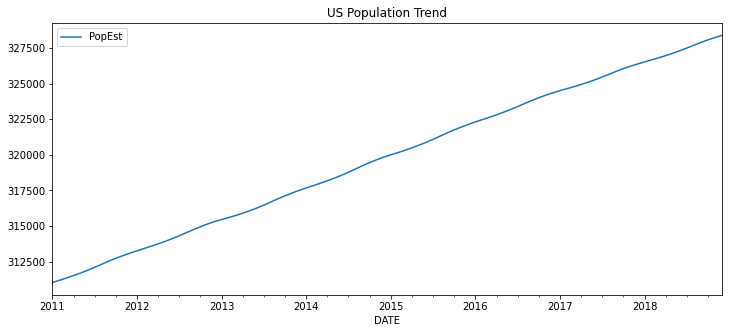

In [277]:
pop.plot(title = "US Population Trend");

In [278]:
pop.shape

(96, 1)

In [279]:
# Set one year as testing (12 months or 96 months less 84 months)
train = pop.iloc[:84]
test = pop.iloc[84:]

In [280]:
# Check lengths
print(train.shape, test.shape)

(84, 1) (12, 1)


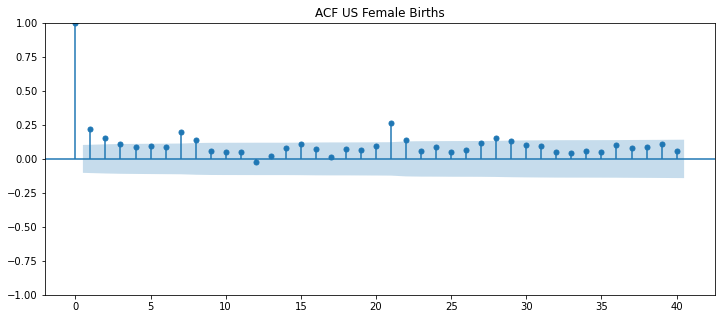

In [301]:
plot_acf(births,lags = 40, title = "ACF US Female Births");

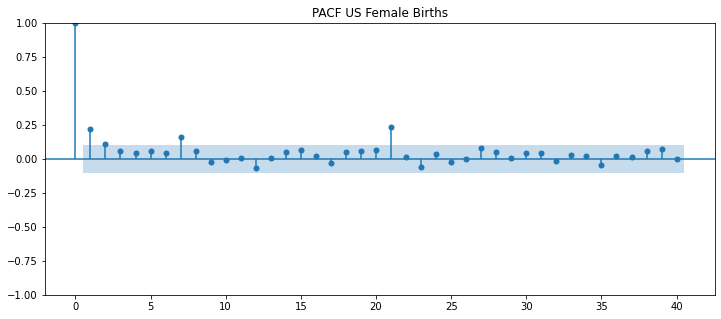

In [302]:
plot_pacf(births,lags = 40, title = "PACF US Female Births");

In [281]:
# Fit model on training data
model = AutoReg(train["PopEst"],lags = 1)
ar1_fit = model.fit()

In [282]:
# Get params
ar1_fit.params

const        284.913797
PopEst.L1      0.999686
dtype: float64

In [283]:
# Set start and end
start = len(train)
end = len(train)+len(test)-1
print(start, end)

84 95


In [284]:
# Predict values given the start and end of the data
predict1 = pd.DataFrame(ar1_fit.predict(start = start, end = end))
predict1

,0
2018-01-01,326560.403377
2018-02-01,326742.749463
2018-03-01,326925.038278
2018-04-01,327107.269838
2018-05-01,327289.444162
2018-06-01,327471.561268
2018-07-01,327653.621173
2018-08-01,327835.623896
2018-09-01,328017.569455
2018-10-01,328199.457868


In [285]:
forecast = pd.concat([test,predict1],axis = 1)
forecast.columns = ["PopEst","Predict"]
forecast.head()

,PopEst,Predict
DATE,,
2018-01-01,326527,326560.403377
2018-02-01,326669,326742.749463
2018-03-01,326812,326925.038278
2018-04-01,326968,327107.269838
2018-05-01,327134,327289.444162


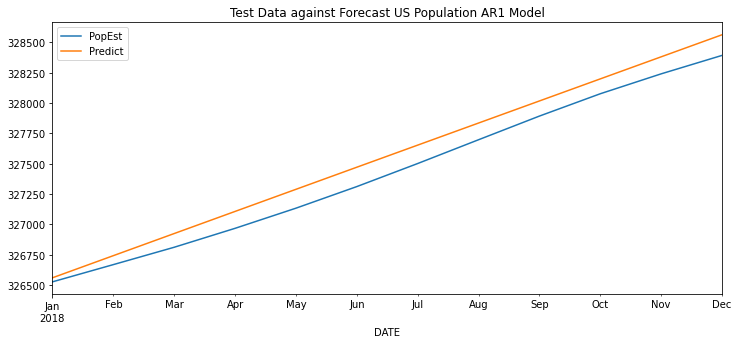

In [286]:
forecast.plot(title = "Test Data against Forecast US Population AR1 Model");

Trend is good but slightly overestimated

## Try AR2 model (2 lags)

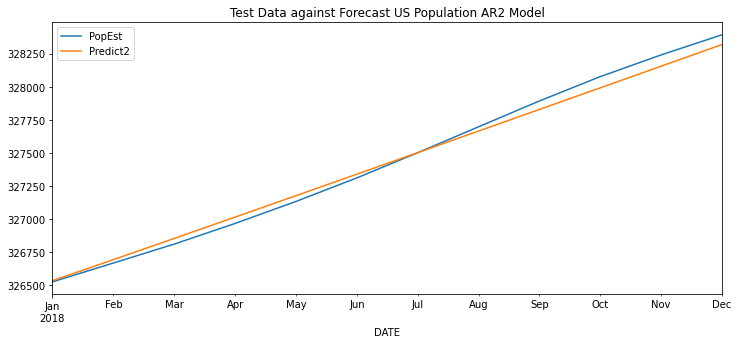

In [287]:
model = AutoReg(train["PopEst"], lags = 2)
ar2_fit = model.fit()
predict2 = pd.DataFrame(ar2_fit.predict(start = start, end = end))
forecast2 = pd.concat([test,predict2],axis = 1)
forecast2.columns = ["PopEst","Predict2"]
forecast2.plot(title = "Test Data against Forecast US Population AR2 Model");

In [288]:
ar2_fit.params

const        137.368305
PopEst.L1      1.853490
PopEst.L2     -0.853836
dtype: float64

## Find the Best Order Value 

In [303]:
# select order (try 10 because there appears from the ACF to be a pattern every 8 to 9 months as we would expect)
model = ar_select_order(train["PopEst"], maxlag=10)
model.ar_lags

[1, 2, 3, 4, 5, 6, 7, 8]

Statsmodels shows AR(8) is the most accurate

In [304]:
model = AutoReg(train["PopEst"], lags = 8)
ar3_fit = model.fit()
ar3_fit.params

const        82.309677
PopEst.L1     2.437997
PopEst.L2    -2.302100
PopEst.L3     1.565427
PopEst.L4    -1.431211
PopEst.L5     1.125022
PopEst.L6    -0.919494
PopEst.L7     0.963694
PopEst.L8    -0.439511
dtype: float64

In [305]:
ar3_fit.aic

488.353052701112

In [306]:
predict1 = ar1_fit.predict(start = start, end = end)
predict2 = ar2_fit.predict(start = start, end = end)
predict3 = ar3_fit.predict(start = start, end = end)

In [307]:
preds = [predict1, predict2, predict3]
labels = ["AR1","AR2","AR8"]

In [308]:
for i in range(3):
    error = mean_squared_error(test["PopEst"],preds[i])
    print(labels[i], error)

AR1 17449.71423587912
AR2 2713.258667805521
AR8 186.97837720677595


In [309]:
forecast = pd.concat([test["PopEst"],predict1,predict2,predict3],axis = 1)
forecast.columns = ["PopEst","AR1","AR2","AR8"]
forecast.head()

,PopEst,AR1,AR2,AR8
DATE,,,,
2018-01-01,326527,326560.403377,326535.672503,326523.865569
2018-02-01,326669,326742.749463,326694.718510,326662.772603
2018-03-01,326812,326925.038278,326854.882250,326805.746942
2018-04-01,326968,327107.269838,327015.944948,326960.064322
2018-05-01,327134,327289.444162,327177.719499,327130.573081


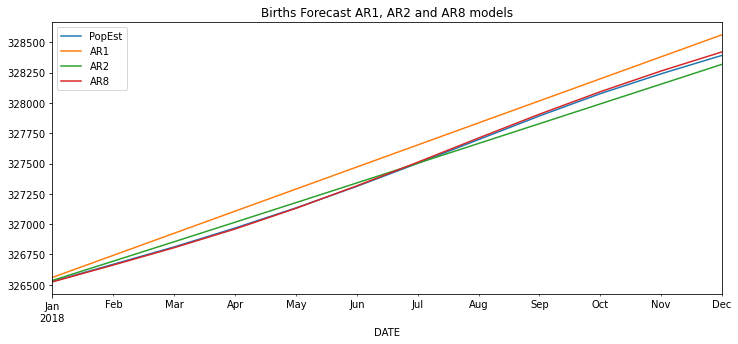

In [310]:
# Plot all three predictions
forecast.plot(title = "Births Forecast AR1, AR2 and AR8 models");

Unsurprisingly a lag of 8 gives the best forecast, so the births estimate 8 lags behind is the best predictor of births at the current time period.

## Forecasting Future Data

In [313]:
# Specify and fit the model on the whole dataset - don't specify maxlags. Forecast only as long as the original test set (12)
model = AutoReg(pop["PopEst"],lags = 8)
ar_fit = model.fit()
forecasted_values = pd.DataFrame(ar_fit.predict(start = len(pop), end = len(pop) + 12))
forecasted_values.columns = ["Forecast"]

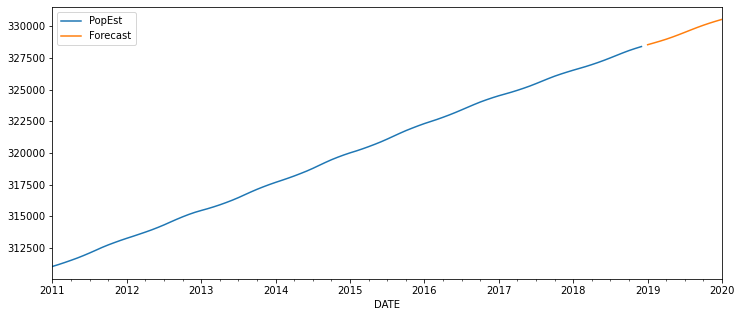

In [314]:
pop["PopEst"].plot(legend = True)
forecasted_values["Forecast"].plot(legend = True);

## Descriptive Statistics and Tests

* Statsmodels include a range of tests to determine stationarity and causality
* Augmented Dickey-Fuller Test: Null Hypothesis is non-stationary data, alternative hypothesis of stationary data if p<0.05
* Grainger causality test to determine if one time series is as useful as another. One time series has causality on changes in another time series. Even if it reports back there is strong causality but there could be another outside factor which is influencing things.
* MAE, MSE, RMSE - measure errors on forecast predictions on known test values
* AIC - information criterion. Evaluates a range of models to allow comparison. Estimates the quality of each model relative to the others. Penalties are used for the number of parameters used to prevent overfitting. Complex models are penalised and simpler models with slightly less performance are preferred.
* BIC - Bayesian Information Criterion is similar.
* Seasonality plots useful to find patterns per season.

## Augmented Dickey-Fuller test for Stationarity

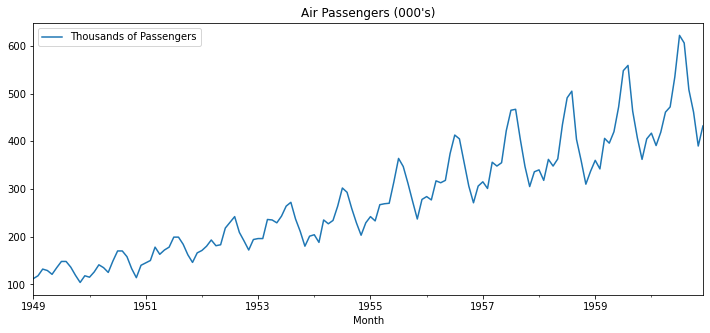

In [315]:
air.plot(title = "Air Passengers (000's)");

In [316]:
# Augmented Dickey-Fuller test for non-stationarity
from statsmodels.tsa.stattools import adfuller
adfuller(air["Thousands of Passengers"])

(0.8153688792060433,
 0.9918802434376409,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.692930839019)

In [317]:
#help(adfuller)

In [318]:
# Construct a formula to print it out neatly

def adf_test (df):
    dftest = adfuller(df)
    df_out = pd.Series(dftest[0:4], index = ["ADF Test Statistic", "P-Value", "Number of Lags","Number of Observations"])
    for key,value in dftest[4].items():
        df_out[f'critical value({key})'] = value
        
    if df_out[1]<0.05:
        print("Reject the Null Hypothesis, the data has no unit root and is stationary")
    else:
        print("Fail to reject the Null Hypothesis, the data has a unit root and is non-stationary")
    return df_out


In [319]:
adf_test(air["Thousands of Passengers"])

Fail to reject the Null Hypothesis, the data has a unit root and is non-stationary


ADF Test Statistic          0.815369
P-Value                     0.991880
Number of Lags             13.000000
Number of Observations    130.000000
critical value(1%)         -3.481682
critical value(5%)         -2.884042
critical value(10%)        -2.578770
dtype: float64

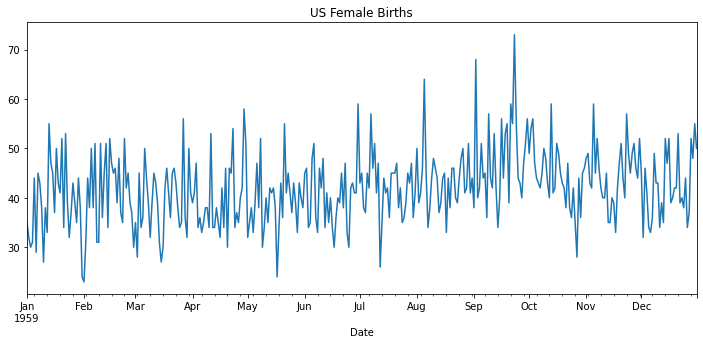

In [320]:
births["Births"].plot(title = "US Female Births");

In [321]:
adf_test(births["Births"])

Reject the Null Hypothesis, the data has no unit root and is stationary


ADF Test Statistic         -4.808291
P-Value                     0.000052
Number of Lags              6.000000
Number of Observations    358.000000
critical value(1%)         -3.448749
critical value(5%)         -2.869647
critical value(10%)        -2.571089
dtype: float64

## Granger Causality Test

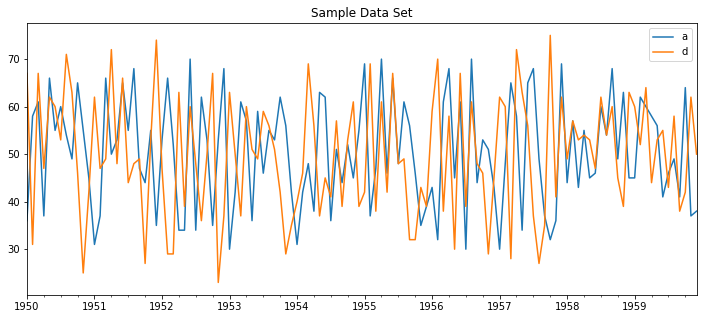

In [322]:
stat[["a","d"]].plot(title = "Sample Data Set");

In [323]:
from statsmodels.tsa.stattools import grangercausalitytests
grangercausalitytests(stat[["a","d"]], maxlag = 3);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7051  , p=0.1942  , df_denom=116, df_num=1
ssr based chi2 test:   chi2=1.7492  , p=0.1860  , df=1
likelihood ratio test: chi2=1.7365  , p=0.1876  , df=1
parameter F test:         F=1.7051  , p=0.1942  , df_denom=116, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=286.0339, p=0.0000  , df_denom=113, df_num=2
ssr based chi2 test:   chi2=597.3806, p=0.0000  , df=2
likelihood ratio test: chi2=212.6514, p=0.0000  , df=2
parameter F test:         F=286.0339, p=0.0000  , df_denom=113, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=188.7446, p=0.0000  , df_denom=110, df_num=3
ssr based chi2 test:   chi2=602.2669, p=0.0000  , df=3
likelihood ratio test: chi2=212.4789, p=0.0000  , df=3
parameter F test:         F=188.7446, p=0.0000  , df_denom=110, df_num=3


At lags 2 and 3, the p-value is zero indicating some causality between the datasets

## Using statsmodels evaluation metrics rather than sklearn (MSE, RMSE, MASE)

In [324]:
from statsmodels.tools.eval_measures import mse, rmse, meanabs

In [325]:
print(rmse(stat["a"],stat["b"]))
print(mse(stat["a"], stat["b"]))
print(meanabs(stat["a"], stat["b"]))

21.588963229699875
466.0833333333333
17.366666666666667


## Seasonality Plots

In [326]:
from statsmodels.graphics.tsaplots import month_plot, quarter_plot

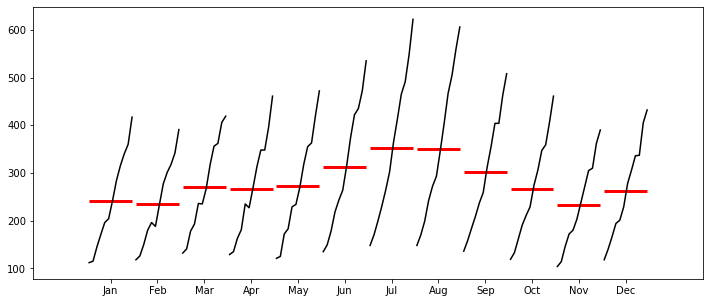

In [327]:
month_plot(air["Thousands of Passengers"]);

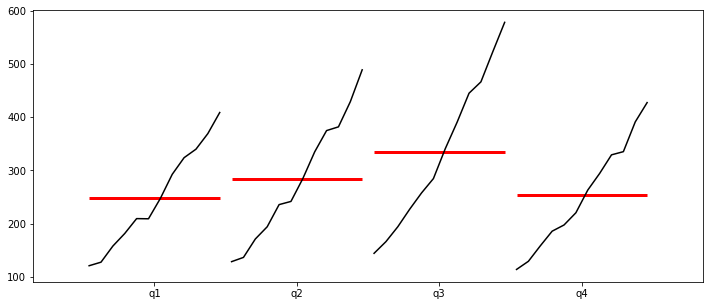

In [328]:
# Resample by quarter before plotting
dfq = air["Thousands of Passengers"].resample(rule = "Q").mean()
quarter_plot(dfq);

# ARIMA Models

* Three components, AR, Integrated and MA component
* AR relates to the relationship with lagged values
* MA component - relates to the error terms, uses the dependency between an observation and a residual error
* Looking at PACF plot, a sharp drop after point k suggests an AR model of order k should be used
* Looking at the ACF plot, a gradual decline suggests to use an MA model 
* Seasonal ARIMA has an additional set of orders
* Best way is to use a gridsearch with an evaluation metric (AIC) to find the best orders rather than relying on the plots to determine this

In [329]:
from pmdarima import auto_arima

In [330]:
#help(auto_arima)

### Births Data

In [357]:
stepwise_fit = auto_arima(births["Births"], start_p = 0, start_q = 0, max_p = 10, max_q = 5, seasonal = False, trace = True);

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2650.760, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2565.234, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2463.584, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2648.768, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2460.154, Time=0.24 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2461.271, Time=0.32 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2460.722, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2536.154, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2463.065, Time=0.65 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2459.074, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2462.221, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2563.261, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2460.367, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0]             : 

In [358]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  365
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1226.537
Date:                Fri, 12 Nov 2021   AIC                           2459.074
Time:                        10:13:21   BIC                           2470.766
Sample:                             0   HQIC                          2463.721
                                - 365                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1252      0.060      2.097      0.036       0.008       0.242
ma.L1         -0.9624      0.017    -56.429      0.000      -0.996      -0.929
sigma2        49.1512      3.250     15.122      0.000      42.781      55.522
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                25.33
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                             0.57
Prob(H) (two-sided):                  0.81   Kurtosis:                         3.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Flights Data

In [360]:
# m is the seasonal frequency
stepwise_fit = auto_arima(air["Thousands of Passengers"], start_p = 1, start_q = 1, max_p = 4, max_q = 4, 
                          seasonal = True, trace = True, m = 12);

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=1022.299, Time=0.42 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1020.393, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1021.003, Time=0.11 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1020.393, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1019.239, Time=0.24 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.80 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=1020.493, Time=0.27 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1032.120, Time=0.17 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1021.120, Time=0.30 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=1021.032, Time=0.42 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1019.178, Time=0.22 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1020.425, Time=0.11 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=1.69 sec
 ARIMA(0,1,1)(1,1,1)[12]     

In [361]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -505.589
Date:                             Fri, 12 Nov 2021   AIC                           1019.178
Time:                                     10:15:02   BIC                           1030.679
Sample:                                          0   HQIC                          1023.851
                                             - 144                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3634      0.074     -4.945      0.000      -0.508      -0.219
ar.S.L12      -0.1239      0.090     -1.372      0.170      -0.301       0.053
ar.S.L24       0.1911      0.107      1.783      0.075      -0.019       0.401
sigma2       130.4480     15.527      8.402      0.000     100.016     160.880
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 4.59
Prob(Q):                              0.92   Prob(JB):                         0.10
Heteroskedasticity (H):               2.70   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## ARMA and ARIMA Models (using ACF and PACF plots)

In [373]:
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima

## Simple ARMA Model

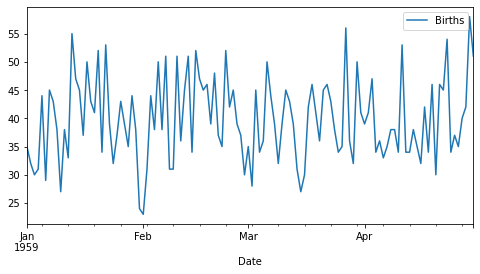

In [375]:
# Take first 120 days of data from the births dataset where the data is pretty much stationary anyway
birthsb = births[:120]
birthsb.plot(figsize = (8,4));

In [376]:
# Confirm stationarity
adf_test(birthsb)

Reject the Null Hypothesis, the data has no unit root and is stationary


ADF Test Statistic       -9.855384e+00
P-Value                   4.373545e-17
Number of Lags            0.000000e+00
Number of Observations    1.190000e+02
critical value(1%)       -3.486535e+00
critical value(5%)       -2.886151e+00
critical value(10%)      -2.579896e+00
dtype: float64

In [377]:
# Set training and test sets for 90 days and fit model
train = birthsb.iloc[:90]
test = birthsb.iloc[90:]

In [380]:
# Set data to float or the model will not predict. Differencing set to 0 as the data is stationary anyway
model = ARIMA(train["Births"].astype('float32'), order=(0, 0, 0))
results = model.fit()

In [381]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Births   No. Observations:                   90
Model:                          ARIMA   Log Likelihood                -308.379
Date:                Fri, 12 Nov 2021   AIC                            620.759
Time:                        10:19:48   BIC                            625.759
Sample:                    01-01-1959   HQIC                           622.775
                         - 03-31-1959                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.7667      0.786     50.609      0.000      38.227      41.307
sigma2        55.4236     10.155      5.458      0.000      35.520      75.327
===================================================================================
Ljung-Box (L1) (Q):                   0.68   Jarque-Bera (JB):                 1.75
Prob(Q):                              0.41   Prob(JB):                         0.42
Heteroskedasticity (H):               0.90   Skew:                             0.06
Prob(H) (two-sided):                  0.79   Kurtosis:                         2.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [382]:
# Predict a months worth of values
start = len(train)
end = len(train) + len(test) -1

In [383]:
predictions = results.predict(start, end).rename("ARMA00")
predictions.head()

1959-04-01    39.766662
1959-04-02    39.766662
1959-04-03    39.766662
1959-04-04    39.766662
1959-04-05    39.766662
Freq: D, Name: ARMA00, dtype: float64

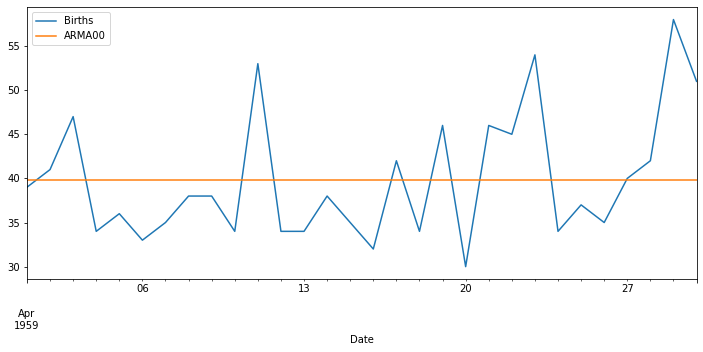

In [384]:
# Plot the test values and the predicted values of the ARMA model
test["Births"].plot(legend = True)
predictions.plot(legend = True);

In [385]:
# Get the mean
test.mean()

Births    39.833333
dtype: float64

The mean of the data shows the model predicts close to the mean average

## ARIMA Model Using Autoarima

### Trade Data

In [386]:
# Bring in new dataset
trade = pd.read_csv("datasets/TradeInventories.csv",index_col = 0, parse_dates = True)
trade.index.freq = "MS"

In [387]:
trade.head()

,Inventories
Date,
1997-01-01,1301161
1997-02-01,1307080
1997-03-01,1303978
1997-04-01,1319740
1997-05-01,1327294


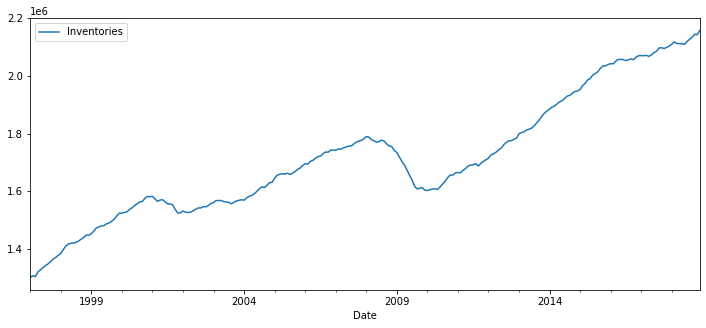

In [388]:
trade.plot();

In [389]:
adf_test(trade["Inventories"])

Fail to reject the Null Hypothesis, the data has a unit root and is non-stationary


ADF Test Statistic         -0.087684
P-Value                     0.950652
Number of Lags              5.000000
Number of Observations    258.000000
critical value(1%)         -3.455953
critical value(5%)         -2.872809
critical value(10%)        -2.572775
dtype: float64

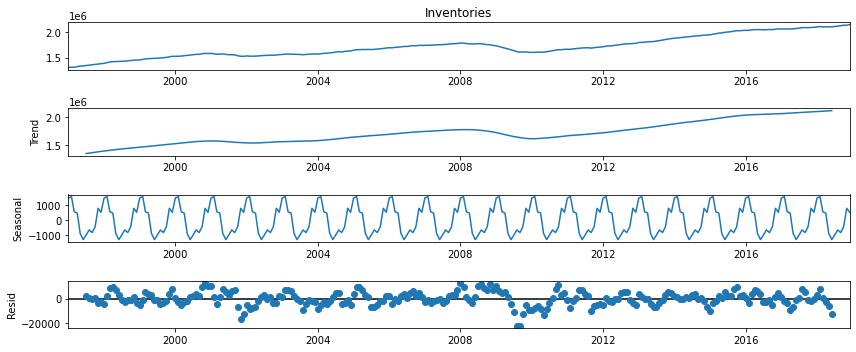

In [390]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(trade["Inventories"], model = "additive")
result.plot();

There is some seasonality but this will be ignored for this example. It is also very small compared to trend

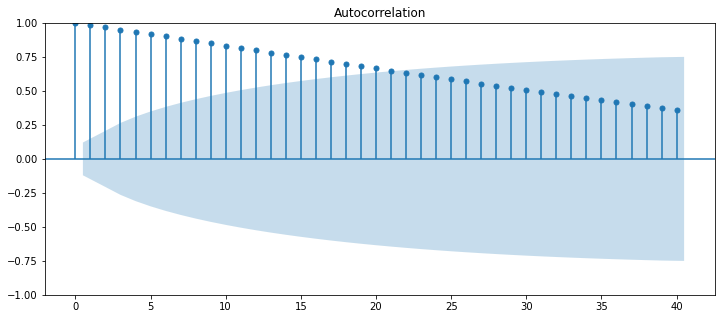

In [425]:
# Plot ACF on orignal undifferenced data
plot_acf(trade["Inventories"],lags = 40);

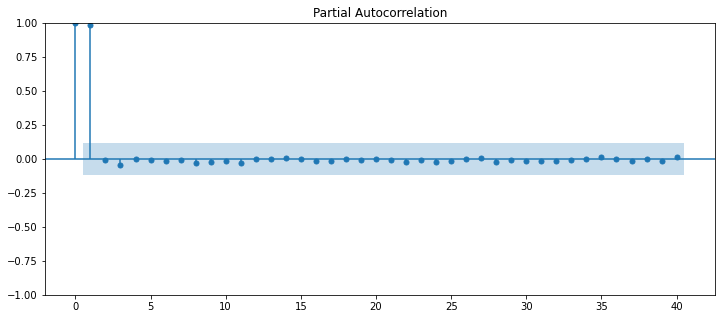

In [426]:
# Plot PACF on undifferenced data
plot_pacf(trade["Inventories"],lags = 40);

In [392]:
# Difference the data
from statsmodels.tsa.statespace.tools import diff
trade["DIFF1"] = diff(trade["Inventories"],k_diff = 1)

In [394]:
# Run the test on the differenced column excluding the NAN - to show that the data is stationary with one order of differencing
## Agrees with the autoarima function. Differencing of 1 is required.
adf_test(trade["DIFF1"].iloc[1:])

Reject the Null Hypothesis, the data has no unit root and is stationary


ADF Test Statistic         -3.412249
P-Value                     0.010548
Number of Lags              4.000000
Number of Observations    258.000000
critical value(1%)         -3.455953
critical value(5%)         -2.872809
critical value(10%)        -2.572775
dtype: float64

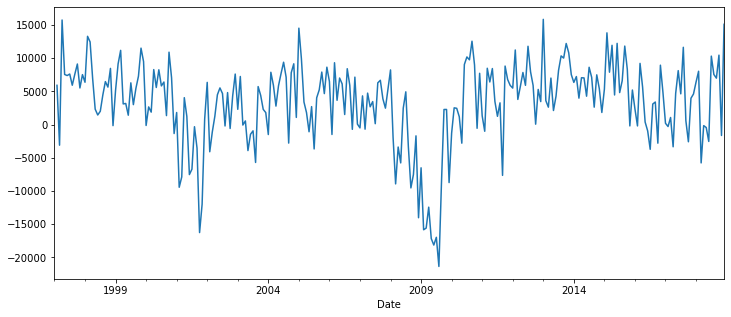

In [395]:
# Plot the differenced data
trade["DIFF1"].plot();

In [428]:
# Run autoarima on the original undifferenced data confirms one order of differencing required
auto_arima(trade["Inventories"], seasonal = False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  264
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2672.018
Date:                Fri, 12 Nov 2021   AIC                           5348.037
Time:                        10:56:55   BIC                           5355.181
Sample:                             0   HQIC                          5350.908
                                - 264                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3258.3802    470.991      6.918      0.000    2335.255    4181.506
sigma2       3.91e+07   2.95e+06     13.250      0.000    3.33e+07    4.49e+07
===================================================================================
Ljung-Box (L1) (Q):                  82.61   Jarque-Bera (JB):               100.74
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -1.15
Prob(H) (two-sided):                  0.48   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Analysing the plots- rule if the PACF of the differenced series shows a sharp cutoff, then consider adding an AR term, the lag where it cuts off is the number of terms.

If the PACF has a sharp cutoff while the ACF decays more slowly with significant lags, then the stationarised series displays an AR pattern, add AR terms rather than MA terms. Set MA to zero or 1.

In this case, with one order of differencing the data becomes stationary and requires no AR or MA orders

In [429]:
# Split into train and test sets
len(trade)

264

In [430]:
train = trade.iloc[:252]
test = trade.iloc[252:]

In [432]:
# Try a (0,0,0) model as the ACF and PACF suggest
model = ARIMA(train["Inventories"].astype('float32'), order=(0,1,0))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Inventories   No. Observations:                  252
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -2579.217
Date:                Fri, 12 Nov 2021   AIC                           5160.434
Time:                        10:57:35   BIC                           5163.959
Sample:                    01-01-1997   HQIC                          5161.852
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.911e+07   4.75e+06     10.330      0.000    3.98e+07    5.84e+07
===================================================================================
Ljung-Box (L1) (Q):                  87.24   Jarque-Bera (JB):               105.61
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.12   Skew:                            -1.20
Prob(H) (two-sided):                  0.62   Kurtosis:                         5.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [434]:
start = len(train)
end = len(train) + len(test)-1
predictions = results.predict(start = start, end = end, typ = 'levels').rename("ARIMA (0,1,0)")
predictions

2018-01-01    2103751.0
2018-02-01    2103751.0
2018-03-01    2103751.0
2018-04-01    2103751.0
2018-05-01    2103751.0
2018-06-01    2103751.0
2018-07-01    2103751.0
2018-08-01    2103751.0
2018-09-01    2103751.0
2018-10-01    2103751.0
2018-11-01    2103751.0
2018-12-01    2103751.0
Freq: MS, Name: ARIMA (0,1,0), dtype: float64

### NOTE - set type to 'levels' to return the predictions as per the original series rather than as a differenced series

<AxesSubplot:xlabel='Date'>

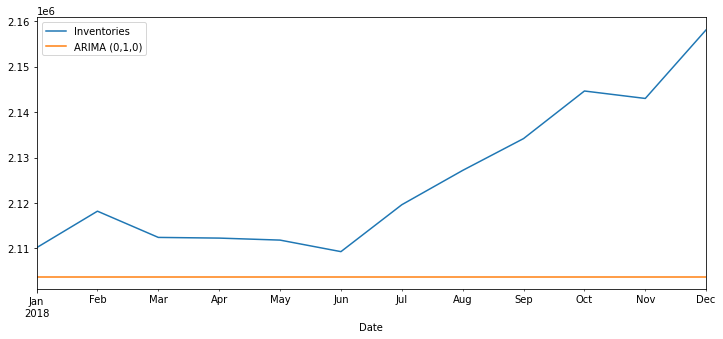

In [435]:
test["Inventories"].plot(legend = True)
predictions.plot(legend = True)

Actually this doesn't pick up the trend in the data at all. Try a different model

<AxesSubplot:xlabel='Date'>

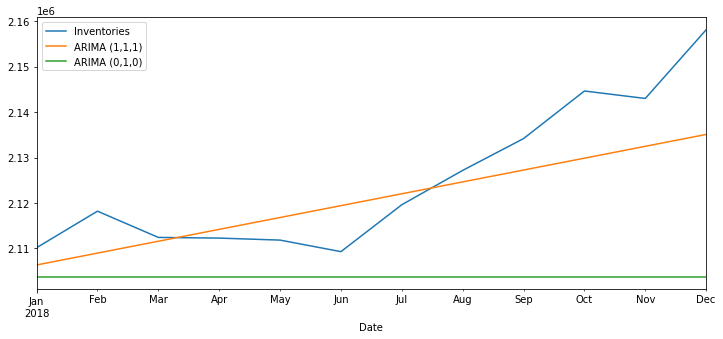

In [436]:
model = ARIMA(train["Inventories"].astype('float32'), order=(1,1,1))
results2 = model.fit()
predictions2 = results2.predict(start = start, end = end, typ = 'levels').rename("ARIMA (1,1,1)")
test["Inventories"].plot(legend = True)
predictions2.plot(legend = True)
predictions.plot(legend = True)

In [437]:
from statsmodels.tools.eval_measures import rmse
error = rmse(test["Inventories"],predictions2)
error

9793.152116696421

In [438]:
test["Inventories"].mean()

2125075.6666666665

In [439]:
predictions2.mean()

2120722.574314211

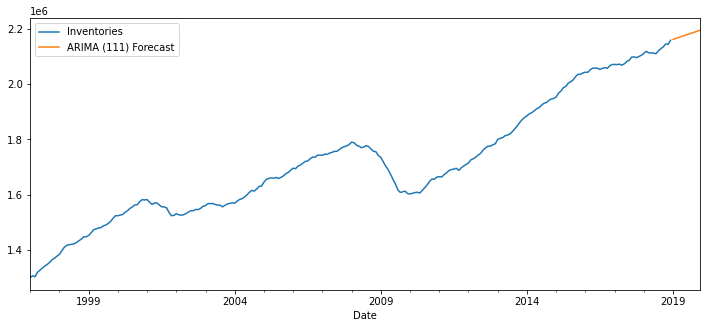

In [441]:
# Forecast into the future - retrain model on all data not just training
model = ARIMA(trade["Inventories"], order = (1,1,1))
results = model.fit()
forecast = results.predict(start = len(trade), end = len(trade)+11, typ = 'levels').rename("ARIMA (111) Forecast")
trade["Inventories"].plot(legend = True)
forecast.plot(legend = True);

# Seasonal ARIMA Models

In [484]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [462]:
co2 = pd.read_csv("datasets/co2_mm_mlo.csv")

In [463]:
co2.head()

,year,month,decimal_date,average,interpolated
0,1958,3,1958.208,315.71,315.71
1,1958,4,1958.292,317.45,317.45
2,1958,5,1958.375,317.50,317.50
3,1958,6,1958.458,NaN,317.10
4,1958,7,1958.542,315.86,315.86


In [464]:
co2["date"] = pd.to_datetime({"Year":co2["year"],"Month":co2["month"],"Day":1})

In [465]:
co2.head()

,year,month,decimal_date,average,interpolated,date
0,1958,3,1958.208,315.71,315.71,1958-03-01
1,1958,4,1958.292,317.45,317.45,1958-04-01
2,1958,5,1958.375,317.50,317.50,1958-05-01
3,1958,6,1958.458,NaN,317.10,1958-06-01
4,1958,7,1958.542,315.86,315.86,1958-07-01


In [502]:
co2.tail()

,year,month,decimal_date,average,interpolated
date,,,,,
2018-07-01,2018,7,2018.542,408.71,408.71
2018-08-01,2018,8,2018.625,406.99,406.99
2018-09-01,2018,9,2018.708,405.51,405.51
2018-10-01,2018,10,2018.792,406.00,406.00
2018-11-01,2018,11,2018.875,408.02,408.02


In [466]:
co2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729 entries, 0 to 728
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   year          729 non-null    int64         
 1   month         729 non-null    int64         
 2   decimal_date  729 non-null    float64       
 3   average       722 non-null    float64       
 4   interpolated  729 non-null    float64       
 5   date          729 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 34.3 KB


In [467]:
co2.set_index("date",inplace = True)
co2.index.freq = "MS"

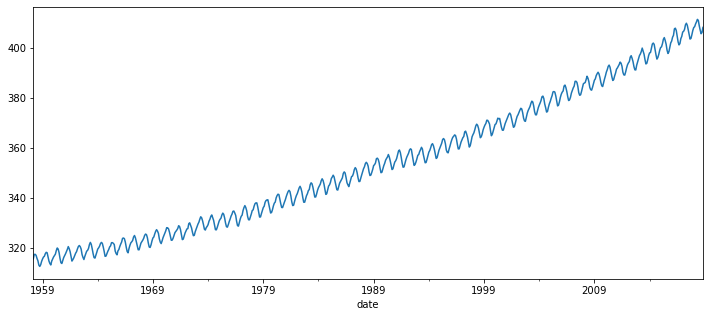

In [472]:
co2.interpolated.plot();

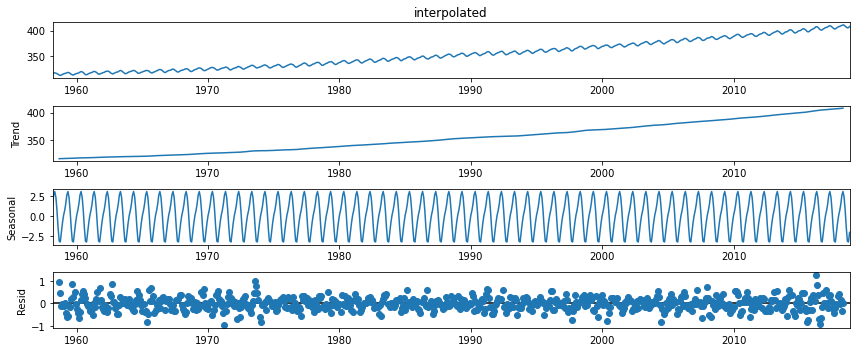

In [475]:
seasonal_decompose(co2.interpolated, model = "additive").plot();

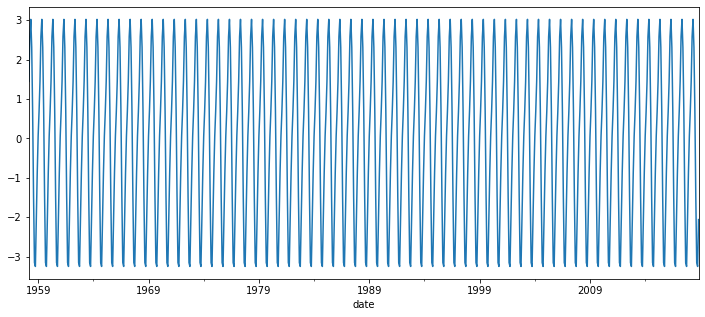

In [478]:
seasonal_decompose(co2.interpolated, model = "additive").seasonal.plot();

In [479]:
auto_arima(co2.interpolated, seasonal = True, m = 12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  729
Model:             SARIMAX(0, 1, 3)x(1, 0, [1], 12)   Log Likelihood                -205.701
Date:                              Fri, 12 Nov 2021   AIC                            423.402
Time:                                      12:04:55   BIC                            450.944
Sample:                                           0   HQIC                           434.029
                                              - 729                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3571      0.036     -9.805      0.000      -0.428      -0.286
ma.L2         -0.0224      0.029     -0.760      0.447      -0.080       0.035
ma.L3         -0.0853      0.034     -2.522      0.012      -0.152      -0.019
ar.S.L12       0.9996      0.000   2870.147      0.000       0.999       1.000
ma.S.L12      -0.8656      0.021    -40.424      0.000      -0.908      -0.824
sigma2         0.0956      0.005     20.523      0.000       0.086       0.105
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 4.00
Prob(Q):                              0.81   Prob(JB):                         0.14
Heteroskedasticity (H):               1.13   Skew:                             0.00
Prob(H) (two-sided):                  0.34   Kurtosis:                         3.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [503]:
len(co2)

729

In [504]:
train = co2.iloc[:717]
test = co2.iloc[717:]

In [498]:
model = SARIMAX(train["interpolated"], order = (0,1,3), seasonal_order = (1,0,1,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                         interpolated   No. Observations:                  717
Model:             SARIMAX(0, 1, 3)x(1, 0, [1], 12)   Log Likelihood                -201.199
Date:                              Fri, 12 Nov 2021   AIC                            414.399
Time:                                      12:12:17   BIC                            441.841
Sample:                                  03-01-1958   HQIC                           424.996
                                       - 11-01-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3542      0.036     -9.792      0.000      -0.425      -0.283
ma.L2         -0.0245      0.033     -0.737      0.461      -0.090       0.041
ma.L3         -0.0875      0.031     -2.826      0.005      -0.148      -0.027
ar.S.L12       0.9996      0.000   2864.673      0.000       0.999       1.000
ma.S.L12      -0.8645      0.023    -37.902      0.000      -0.909      -0.820
sigma2         0.0951      0.005     20.292      0.000       0.086       0.104
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 4.26
Prob(Q):                              0.78   Prob(JB):                         0.12
Heteroskedasticity (H):               1.15   Skew:                             0.02
Prob(H) (two-sided):                  0.29   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [509]:
start = len(train)
end = len(train) + len(test)-1

In [510]:
predictions = results.predict(start, end, type = "levels").rename("ARIMASeas")
predictions

2017-12-01    406.610603
2018-01-01    407.826455
2018-02-01    408.579765
2018-03-01    409.484924
2018-04-01    411.044278
2018-05-01    411.647737
2018-06-01    410.866378
2018-07-01    409.175124
2018-08-01    407.074862
2018-09-01    405.625067
2018-10-01    405.896852
2018-11-01    407.431610
Freq: MS, Name: ARIMASeas, dtype: float64

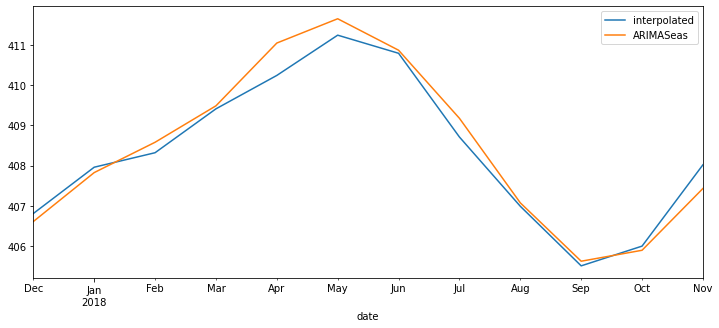

In [512]:
test["interpolated"].plot(legend = True)
predictions.plot(legend = True);

In [518]:
error = rmse(test["interpolated"],predictions)
error

0.3586149413329089

In [519]:
test["interpolated"].mean()

408.3333333333333

### Forecast into the Future

In [527]:
model = SARIMAX(co2["interpolated"], order = (0,1,3) , seasonal_order = (1,0,1,12))
results = model.fit()

In [528]:
forecast = results.predict(start = len(co2), end = len(co2)+11, typ = 'levels').rename("ARIMAFORECAST")

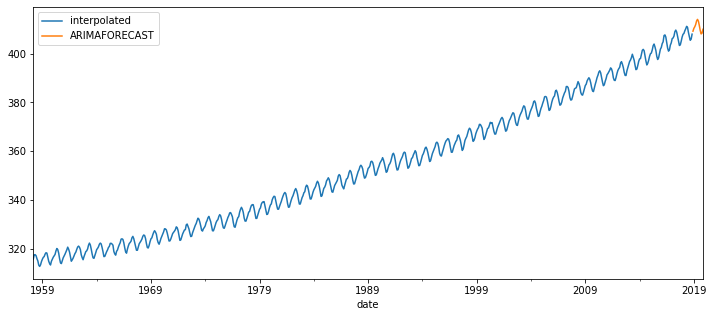

In [532]:
co2["interpolated"].plot(legend = True)
forecast.plot(legend = True);

# Exogenous Regressor Models

* The SARIMAX function also supports exogenous variables (supplemental information which is not historical label information)
* Exogenous variables should all be numerical (one-hot encoding, dummy variables with pandas get_dummies etc)
* Try correlation to see if there might be a relationship

In [537]:
rest = pd.read_csv("datasets/RestaurantVisitors.csv", index_col = "date", parse_dates = True)
rest.shape

(517, 8)

In [536]:
rest.index.freq = "D"

In [535]:
rest.head()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2016-01-01,Friday,1,New Year's Day,65.0,25.0,67.0,139.0,296.0
2016-01-02,Saturday,0,na,24.0,39.0,43.0,85.0,191.0
2016-01-03,Sunday,0,na,24.0,31.0,66.0,81.0,202.0
2016-01-04,Monday,0,na,23.0,18.0,32.0,32.0,105.0
2016-01-05,Tuesday,0,na,2.0,15.0,38.0,43.0,98.0


In [538]:
rest.tail()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2017-05-27,Saturday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-28,Sunday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-29,Monday,1,Memorial Day,NaN,NaN,NaN,NaN,NaN
2017-05-30,Tuesday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-31,Wednesday,0,na,NaN,NaN,NaN,NaN,NaN


In [540]:
# Drop missing data
rest1 = rest.dropna()
rest1.shape

(478, 8)

In [546]:
rest1.columns

Index(['weekday', 'holiday', 'holiday_name', 'rest1', 'rest2', 'rest3',
       'rest4', 'total'],
      dtype='object')

In [548]:
# Set the data in the restaurant columns to integer from float
cols = ['rest1', 'rest2', 'rest3','rest4','total']
for col in cols:
    rest1[col] = rest1[col].astype(int)

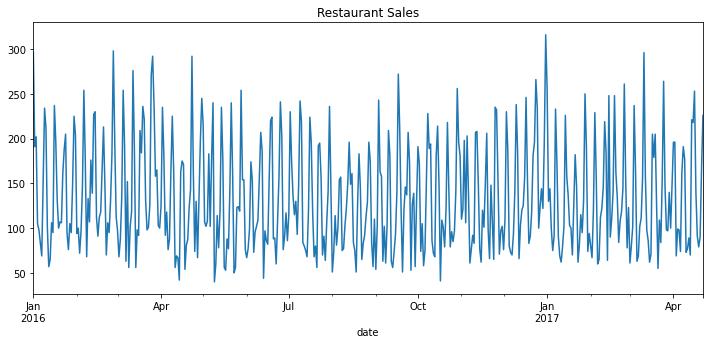

In [552]:
rest1["total"].plot(title = "Restaurant Sales");

### Does the holiday affect the sales?

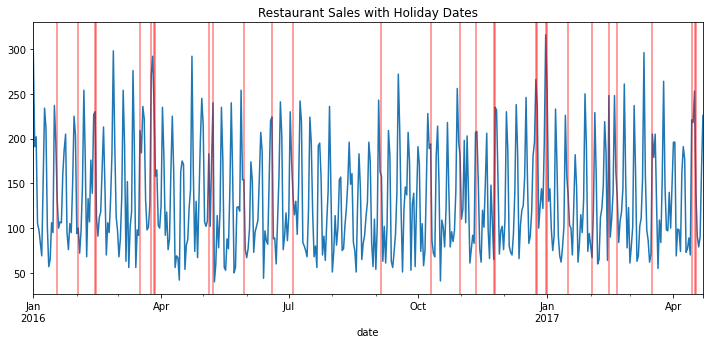

In [554]:
ax = rest1["total"].plot(title = "Restaurant Sales with Holiday Dates")

# Return dates where the entry is a holiday
for day in rest1[rest1["holiday"] ==1].index:
    ax.axvline(x = day, color = "r", alpha = 0.5);
    
#for x in rest1.query('holiday ==1').index (alternative)

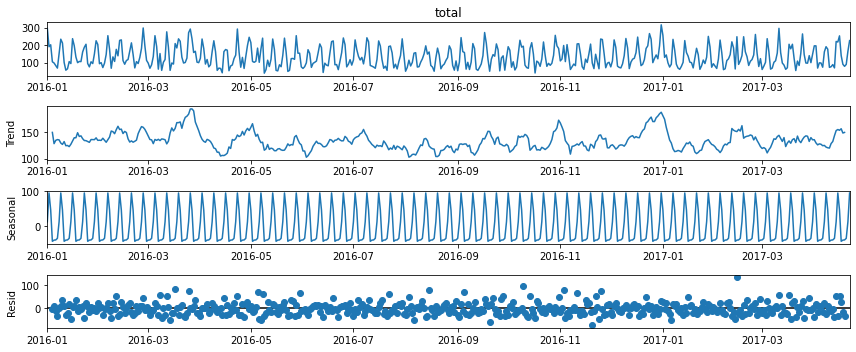

In [556]:
seasonal_decompose(rest1["total"]).plot();

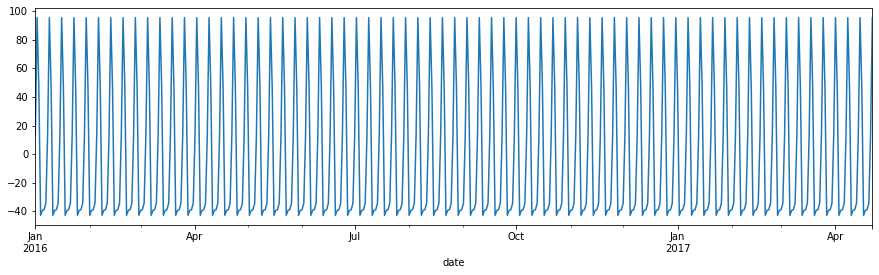

In [560]:
seasonal_decompose(rest1["total"]).seasonal.plot(figsize = (15,4));

In [561]:
len(rest1)

478

## SARIMA (no exogenous variable)

In [564]:
# USE ALL THE DATA TO GET THE ORDERS NOT JUST THE TRAINING DATA
results = auto_arima(rest1["total"], seasonal = True, m = 7).summary()

In [565]:
results

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:                         y   No. Observations:                  478
Model:             SARIMAX(1, 0, [1], 7)   Log Likelihood               -2383.026
Date:                   Fri, 12 Nov 2021   AIC                           4774.052
Time:                           12:49:01   BIC                           4790.730
Sample:                                0   HQIC                          4780.609
                                   - 478                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.9606      1.567      2.528      0.011       0.890       7.032
ar.S.L7        0.9664      0.012     78.192      0.000       0.942       0.991
ma.S.L7       -0.7450      0.050    -14.812      0.000      -0.844      -0.646
sigma2      1253.6750     76.509     16.386      0.000    1103.719    1403.631
===================================================================================
Ljung-Box (L1) (Q):                  15.07   Jarque-Bera (JB):                65.68
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             0.74
Prob(H) (two-sided):                  0.34   Kurtosis:                         4.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [562]:
# Train test split
train = rest1.iloc[:436]
test = rest1.iloc[436:] # month

In [567]:
# Enforce invertability = False (may be removed in future versions)
model = SARIMAX(train["total"], order = (0,0,0), seasonal_order = (1,0,1,7), enforce_invertability = False)

The most recent observations have higher weight than those in the past but where more distant observations have more weight than current, this needs to be adjusted as statsmodels forces theta to be less than one and returns an error. 

In [568]:
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:                     total   No. Observations:                  436
Model:             SARIMAX(1, 0, [1], 7)   Log Likelihood               -2165.369
Date:                   Fri, 12 Nov 2021   AIC                           4336.738
Time:                           15:23:13   BIC                           4348.970
Sample:                       01-01-2016   HQIC                          4341.565
                            - 03-11-2017                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7        0.9999   9.58e-05   1.04e+04      0.000       1.000       1.000
ma.S.L7       -0.9383      0.024    -39.199      0.000      -0.985      -0.891
sigma2      1111.8059     58.739     18.928      0.000     996.679    1226.932
===================================================================================
Ljung-Box (L1) (Q):                  15.40   Jarque-Bera (JB):                83.56
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                             0.72
Prob(H) (two-sided):                  0.81   Kurtosis:                         4.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [569]:
start = len(train)
end = len(train) + len(test) -1
predictions = results.predict(start = start, end = end).rename("SARIMA MODEL")

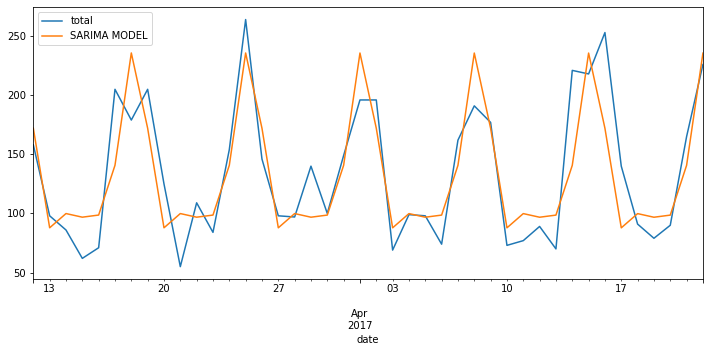

In [572]:
test["total"].plot(legend = True)
predictions.plot(legend = True);

### Add in Holidays

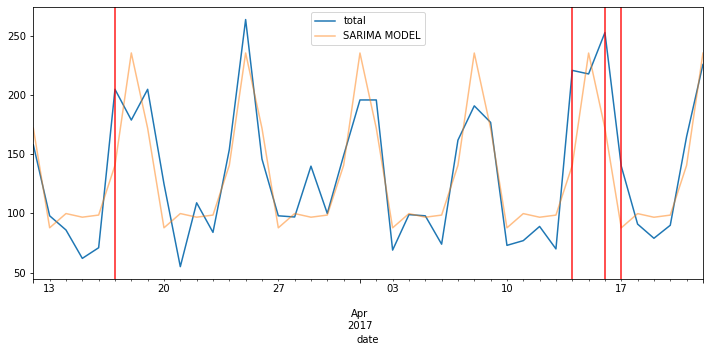

In [591]:
ax = test["total"].plot(legend = True)
predictions.plot(legend = True, alpha = 0.5)
for day in test[test["holiday"] ==1].index:
    ax.axvline(x = day, color = "r", alpha = 0.9);

The peaks where there are holidays are not picked up by the model as they are not included.

In [592]:
error = rmse(predictions,test["total"])

In [593]:
error

31.913781595325716

In [594]:
test["total"].mean()

134.26190476190476

## Add holidays into the dataset

The exogenous needs to be known in the future to do the forecast, you cannot forecast this variable as well.

In [595]:
auto_arima(rest1["total"], exogenous = rest1[["holiday"]], seasonal = True, m = 7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  478
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 7)   Log Likelihood               -2355.666
Date:                             Fri, 12 Nov 2021   AIC                           4723.332
Time:                                     15:52:00   BIC                           4748.350
Sample:                                 01-01-2016   HQIC                          4733.168
                                      - 04-22-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     20.2956      3.405      5.961      0.000      13.622      26.969
holiday       55.7337      4.570     12.194      0.000      46.776      64.692
ar.L1          0.0557      0.049      1.140      0.254      -0.040       0.151
ar.S.L7        0.8522      0.025     34.555      0.000       0.804       0.901
ma.S.L7       -0.4441      0.062     -7.119      0.000      -0.566      -0.322
sigma2      1076.6855     75.734     14.217      0.000     928.250    1225.121
===================================================================================
Ljung-Box (L1) (Q):                  12.02   Jarque-Bera (JB):                 5.78
Prob(Q):                              0.00   Prob(JB):                         0.06
Heteroskedasticity (H):               0.90   Skew:                             0.27
Prob(H) (two-sided):                  0.49   Kurtosis:                         3.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [596]:
model = SARIMAX(train["total"], exog = train[["holiday"]], order = (1,0,0), seasonal_order = (1,0,1,7),
                enforce_invertability = False)

In [598]:
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               total   No. Observations:                  436
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 7)   Log Likelihood               -2089.062
Date:                             Fri, 12 Nov 2021   AIC                           4188.124
Time:                                     15:53:35   BIC                           4208.512
Sample:                                 01-01-2016   HQIC                          4196.170
                                      - 03-11-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday       68.5104      3.763     18.204      0.000      61.134      75.887
ar.L1          0.2115      0.044      4.804      0.000       0.125       0.298
ar.S.L7        0.9999   8.98e-05   1.11e+04      0.000       1.000       1.000
ma.S.L7       -0.9461      0.023    -41.630      0.000      -0.991      -0.902
sigma2       783.3939     45.147     17.352      0.000     694.908     871.880
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):                20.24
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                             0.23
Prob(H) (two-sided):                  0.84   Kurtosis:                         3.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

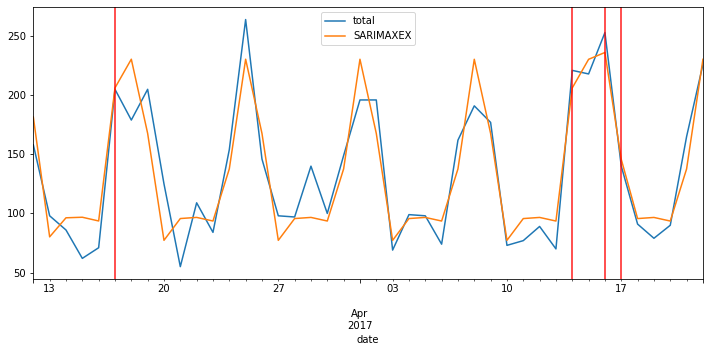

In [608]:
predictions = results.predict(start = start, end = end, exog = test[["holiday"]]).rename("SARIMAXEX")
ax = test["total"].plot(legend = True)
ax = predictions.plot(legend = True)
for day in test[test["holiday"] ==1].index:
    ax.axvline(x = day, color = "r", alpha = 0.9);

In [610]:
error = rmse(predictions,test["total"])
error

23.26361129875217

In [611]:
test["total"].mean()

134.26190476190476

### Forecast

In [612]:
model = SARIMAX(rest1["total"], exog = rest1[["holiday"]], order = (1,0,0), seasonal_order = (1,0,1,7),
                enforce_invertability = False)

In [614]:
results = model.fit()

In [619]:
rest.tail()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2017-05-27,Saturday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-28,Sunday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-29,Monday,1,Memorial Day,NaN,NaN,NaN,NaN,NaN
2017-05-30,Tuesday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-31,Wednesday,0,na,NaN,NaN,NaN,NaN,NaN


In [622]:
# Subset from line 478 where we know the holidays but not the sales
exog_forecast = rest[478:][["holiday"]]
exog_forecast.head()

,holiday
date,
2017-04-23,0
2017-04-24,0
2017-04-25,0
2017-04-26,0
2017-04-27,0


In [627]:
forecast = results.predict(len(rest1),len(rest1) + 38, exog = exog_forecast).rename("SARIMAXFORECAST")

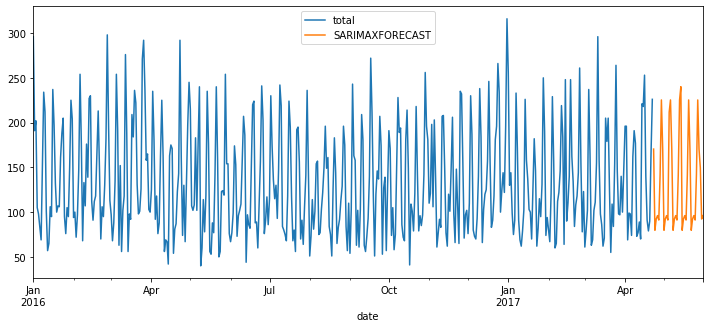

In [634]:
ax = rest1["total"].plot(legend = True)
ax = forecast.plot(legend = True);

# Vector Autoregression

* Previous models the forecast variable was influenced by the outside variable but not in reverse. In some cases variables affect each other.
* Vector autoregression can deal with this. All variables in the model has an equation based of its own lagged variables.
* Each variable is defined with an equation using the other variables each lagged by the number of time periods
* Analyze the time series characteristics
* Test for causation amongst the time series
* Test for stationarity
* Transform the series to make it stationary, if needed
* Find optimal order (p)
* Prepare training and test datasets
* Train the model
* Roll back the transformations, if any.
* Evaluate the model using test set
* Forecast to future

In [768]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [672]:
# Load datasets
m = pd.read_csv("datasets/M2SLMoneyStock.csv", index_col = 0, parse_dates = True)
s = pd.read_csv("datasets/PCEPersonalSpending.csv", index_col = 0, parse_dates = True)
m.index.freq = "MS"
s.index.freq = "MS"
print(m.shape, s.shape)

(252, 1) (252, 1)


In [673]:
# Join the datasets
df = m.join(s)

In [674]:
# Check for null values
df.isnull().sum()

Money       0
Spending    0
dtype: int64

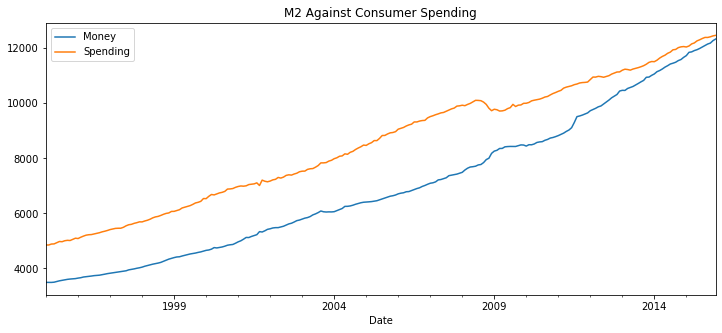

In [675]:
df.plot(title = "M2 Against Consumer Spending");

In [676]:
# Check for stationarity
adf_test(df["Money"])

Fail to reject the Null Hypothesis, the data has a unit root and is non-stationary


ADF Test Statistic          4.239022
P-Value                     1.000000
Number of Lags              4.000000
Number of Observations    247.000000
critical value(1%)         -3.457105
critical value(5%)         -2.873314
critical value(10%)        -2.573044
dtype: float64

In [677]:
adf_test(df["Spending"])

Fail to reject the Null Hypothesis, the data has a unit root and is non-stationary


ADF Test Statistic          0.149796
P-Value                     0.969301
Number of Lags              3.000000
Number of Observations    248.000000
critical value(1%)         -3.456996
critical value(5%)         -2.873266
critical value(10%)        -2.573019
dtype: float64

In [678]:
df_transformed = df.diff()
df_transformed.head()

,Money,Spending
Date,,
1995-01-01,NaN,NaN
1995-02-01,-2.5,-0.4
1995-03-01,1.2,34.6
1995-04-01,8.1,4.8
1995-05-01,25.0,42.9


In [679]:
adf_test(df_transformed["Money"].dropna())

Fail to reject the Null Hypothesis, the data has a unit root and is non-stationary


ADF Test Statistic         -2.057404
P-Value                     0.261984
Number of Lags             15.000000
Number of Observations    235.000000
critical value(1%)         -3.458487
critical value(5%)         -2.873919
critical value(10%)        -2.573367
dtype: float64

Remains non-stationary with first order differencing

In [680]:
adf_test(df_transformed["Spending"].dropna())

Reject the Null Hypothesis, the data has no unit root and is stationary


ADF Test Statistic       -7.226974e+00
P-Value                   2.041027e-10
Number of Lags            2.000000e+00
Number of Observations    2.480000e+02
critical value(1%)       -3.456996e+00
critical value(5%)       -2.873266e+00
critical value(10%)      -2.573019e+00
dtype: float64

Even though the second series is stationary, you don't want an uneven number of nan values resulting from the differencing so the stationary series is differenced again along with the non-stationary so there is a second order differencing from both

In [681]:
df_transformed = df_transformed.diff()
df_transformed.head()

,Money,Spending
Date,,
1995-01-01,NaN,NaN
1995-02-01,NaN,NaN
1995-03-01,3.7,35.0
1995-04-01,6.9,-29.8
1995-05-01,16.9,38.1


In [740]:
df_transformed.tail()

,Money,Spending
Date,,
2015-08-01,-0.7,-8.5
2015-09-01,5.5,-39.8
2015-10-01,-23.1,24.5
2015-11-01,55.8,10.7
2015-12-01,-31.2,-15.0


In [684]:
df_transformed = df_transformed.dropna()

In [685]:
adf_test(df_transformed["Money"])

Reject the Null Hypothesis, the data has no unit root and is stationary


ADF Test Statistic       -7.077471e+00
P-Value                   4.760675e-10
Number of Lags            1.400000e+01
Number of Observations    2.350000e+02
critical value(1%)       -3.458487e+00
critical value(5%)       -2.873919e+00
critical value(10%)      -2.573367e+00
dtype: float64

In [686]:
adf_test(df_transformed["Spending"])

Reject the Null Hypothesis, the data has no unit root and is stationary


ADF Test Statistic       -8.760145e+00
P-Value                   2.687900e-14
Number of Lags            8.000000e+00
Number of Observations    2.410000e+02
critical value(1%)       -3.457779e+00
critical value(5%)       -2.873609e+00
critical value(10%)      -2.573202e+00
dtype: float64

The money column is now stationary as is the spending column

In [687]:
df_transformed.shape

(250, 2)

In [689]:
# Number of observations
obs = 12

In [692]:
train = df_transformed[:-obs]
test = df_transformed[-obs:]
print(train.shape, test.shape)

In [741]:
test.tail()

,Money,Spending
Date,,
2015-08-01,-0.7,-8.5
2015-09-01,5.5,-39.8
2015-10-01,-23.1,24.5
2015-11-01,55.8,10.7
2015-12-01,-31.2,-15.0


In [710]:
# Choose the order of the auto vector regression model to find p
model = VAR(train)
for p in [1,2,3,4,5,6,7]:
    results = model.fit(p)
    print(f'ORDER:{p}')
    print(f'AIC:{results.aic}')
    print('\n')

ORDER:1
AIC:14.178610495220896


ORDER:2
AIC:13.955189367163703


ORDER:3
AIC:13.849518291541038


ORDER:4
AIC:13.827950574458281


ORDER:5
AIC:13.78730034460964


ORDER:6
AIC:13.799076756885809


ORDER:7
AIC:13.79763872791397




Order 5 looks to have the lowest AIC

In [711]:
results = model.fit(5)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 15, Nov, 2021
Time:                     11:24:19
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    14.1131
Nobs:                     233.000    HQIC:                   13.9187
Log likelihood:          -2245.45    FPE:                    972321.
AIC:                      13.7873    Det(Omega_mle):         886628.
--------------------------------------------------------------------
Results for equation Money
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.516683         1.782238            0.290           0.772
L1.Money           -0.646232         0.068177           -9.479           0.000
L1.Spending        -0.107411         0.051388           -2.090      

### Forecasting Values

In [738]:
# Predict the next 12 values (need a numpy array for order 5 and 2 variables (p x k))
# Need to get the five lagged values right before the test set starts
print(train.values.shape)
lagged_values = train.values[-5:]
lagged_values

(238, 2)


array([[-31.9,  40.3],
       [  5.6, -70.7],
       [ 25.5,  52.5],
       [-21.3, -37.2],
       [ 39.5, -17.8]])

In [739]:
# Forecast from the end of the training set onwards for 12 periods
forecasted_values = results.forecast(y = lagged_values, steps = 12)
forecasted_values

array([[-16.99527634,  36.14982003],
       [ -3.17403756, -11.45029844],
       [ -0.377725  ,  -6.68496939],
       [ -2.60223305,   5.47945777],
       [  4.228557  ,  -2.44336505],
       [  1.55939341,   0.38763902],
       [ -0.99841027,   3.88368011],
       [  0.36451042,  -2.3561014 ],
       [ -1.21062726,  -1.22414652],
       [  0.22587712,   0.786927  ],
       [  1.33893884,   0.18097449],
       [ -0.21858453,   0.21275046]])

In [734]:
# Dataframe of forecasted values covering 12 points into the test set (same period)
idx = pd.date_range('2015-01-01', periods = 12, freq = 'MS')
f = pd.DataFrame(forecasted_values, index = idx, columns = ['Money_2d','Spending_2d'])
f

,Money_2d,Spending_2d
2015-01-01,-16.995276,36.149820
2015-02-01,-3.174038,-11.450298
2015-03-01,-0.377725,-6.684969
2015-04-01,-2.602233,5.479458
2015-05-01,4.228557,-2.443365
2015-06-01,1.559393,0.387639
2015-07-01,-0.998410,3.883680
2015-08-01,0.364510,-2.356101
2015-09-01,-1.210627,-1.224147
2015-10-01,0.225877,0.786927


### Invert the transformations

In [755]:
# Need to account for the differencing to compare with the test set. Need to reverse the first and second differences

# 
f["Money_1d"] = (df["Money"].iloc[-obs-1] - df['Money'].iloc[-obs-2]) + f['Money_2d'].cumsum()
f['MoneyForecast'] = df['Money'].iloc[-obs-1] + f["Money_1d"].cumsum()

# 
f["Spending_1d"] = (df["Spending"].iloc[-obs-1] - df["Spending"].iloc[-obs-2]) + f["Spending_2d"].cumsum()
f["SpendingForecast"] = df["Spending"].iloc[-obs-1] + f["Spending_1d"].cumsum()


In [756]:
f.head()

,Money_2d,Spending_2d,Money_1d,MoneyForecast,Spending_1d,SpendingForecast
2015-01-01,-16.995276,36.149820,61.604724,11731.704724,46.749820,12108.749820
2015-02-01,-3.174038,-11.450298,58.430686,11790.135410,35.299522,12144.049342
2015-03-01,-0.377725,-6.684969,58.052961,11848.188371,28.614552,12172.663894
2015-04-01,-2.602233,5.479458,55.450728,11903.639099,34.094010,12206.757904
2015-05-01,4.228557,-2.443365,59.679285,11963.318384,31.650645,12238.408549


In [757]:
test_range = df[-obs:]
test_range

,Money,Spending
Date,,
2015-01-01,11733.2,12046.0
2015-02-01,11852.4,12082.4
2015-03-01,11868.8,12158.3
2015-04-01,11916.1,12193.8
2015-05-01,11947.6,12268.1
2015-06-01,11993.1,12308.3
2015-07-01,12045.3,12355.4
2015-08-01,12096.8,12394.0
2015-09-01,12153.8,12392.8


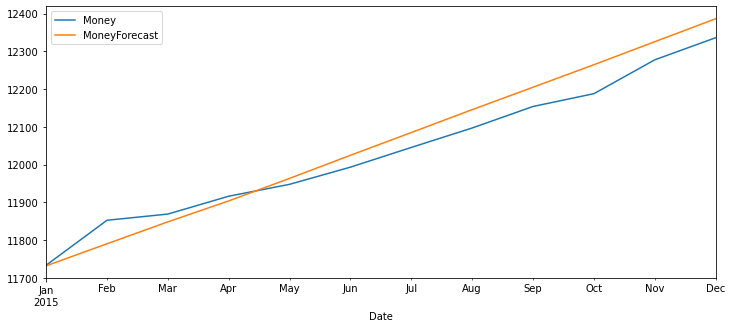

In [761]:
test_range["Money"].plot(legend = True)
f["MoneyForecast"].plot(legend = True);

In [765]:
print(rmse(test_range["Money"], f["MoneyForecast"]))
print(test_range["Money"].mean())

43.71049653558893
12034.008333333333


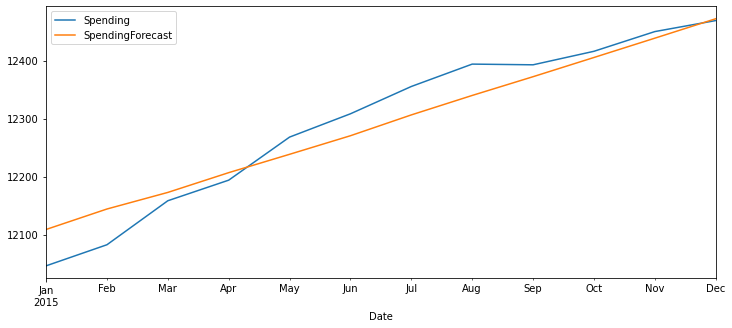

In [762]:
test_range["Spending"].plot(legend = True)
f["SpendingForecast"].plot(legend = True);

In [767]:
print(rmse(test_range["Spending"], f["SpendingForecast"]))
print(test_range["Spending"].mean())

37.00117516940808
12294.533333333333


# VARMA Model

* Includes the Moving Average term
* Auto arima can be used here

In [772]:
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults

In [774]:
auto_arima(df["Money"], max_iter = 1000)

ARIMA(order=(1, 2, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [775]:
auto_arima(df["Spending"], max_iter = 1000)

ARIMA(order=(1, 1, 2), scoring_args={}, suppress_warnings=True)

The differencing identified in the previous section is shown. p = 1, q = 2

In [805]:
df_transformed = df.diff().diff().dropna()

In [806]:
df_transformed.head()

,Money,Spending
Date,,
1995-03-01,3.7,35.0
1995-04-01,6.9,-29.8
1995-05-01,16.9,38.1
1995-06-01,-0.3,1.5
1995-07-01,-6.2,-51.7


In [813]:
train = df_transformed[0:-obs]
test = df_transformed[-obs:]

In [814]:
print(train.shape, test.shape)

(238, 2) (12, 2)


In [824]:
model = VARMAX(train, order = (1,2),trend = 'c')
results = model.fit(max_iter = 1000, disp = False)
results.summary()

Dep. Variable:,"['Money', 'Spending']",No. Observations:,238
Model:,"VARMA(1,2)",Log Likelihood,-2291.693
,+ intercept,AIC,4617.387
Date:,"Mon, 15 Nov 2021",BIC,4676.415
Time:,14:46:54,HQIC,4641.176
Sample:,03-01-1995,,
,- 12-01-2014,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.39, 0.29",Jarque-Bera (JB):,"689.24, 123.51"
Prob(Q):,"0.53, 0.59",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"6.17, 2.58",Skew:,"1.48, -0.28"


In [825]:
df_forecast = results.forecast(12)
df_forecast.head()

,Money,Spending
2015-01-01,-17.307674,38.198246
2015-02-01,-10.825166,-7.459853
2015-03-01,3.723949,3.084138
2015-04-01,-1.053132,-0.649242
2015-05-01,0.444460,0.726174


In [826]:
# Invert the transformation
df_forecast["Money_1d"] = (df["Money"].iloc[-obs-1] - df['Money'].iloc[-obs-2]) + df_forecast['Money'].cumsum()
df_forecast['MoneyForecast'] = df['Money'].iloc[-obs-1] + df_forecast["Money_1d"].cumsum()
 
df_forecast["Spending_1d"] = (df["Spending"].iloc[-obs-1] - df["Spending"].iloc[-obs-2]) + df_forecast["Spending"].cumsum()
df_forecast["SpendingForecast"] = df["Spending"].iloc[-obs-1] + df_forecast["Spending_1d"].cumsum()

In [827]:
df_forecast.head()

,Money,Spending,Money_1d,MoneyForecast,Spending_1d,SpendingForecast
2015-01-01,-17.307674,38.198246,61.292326,11731.392326,48.798246,12110.798246
2015-02-01,-10.825166,-7.459853,50.467160,11781.859486,41.338393,12152.136639
2015-03-01,3.723949,3.084138,54.191108,11836.050594,44.422532,12196.559171
2015-04-01,-1.053132,-0.649242,53.137976,11889.188570,43.773290,12240.332461
2015-05-01,0.444460,0.726174,53.582436,11942.771006,44.499464,12284.831925


In [828]:
final = pd.concat([df.iloc[-12:], df_forecast[["MoneyForecast","SpendingForecast"]]], axis = 1)
final.head()

,Money,Spending,MoneyForecast,SpendingForecast
Date,,,,
2015-01-01,11733.2,12046.0,11731.392326,12110.798246
2015-02-01,11852.4,12082.4,11781.859486,12152.136639
2015-03-01,11868.8,12158.3,11836.050594,12196.559171
2015-04-01,11916.1,12193.8,11889.188570,12240.332461
2015-05-01,11947.6,12268.1,11942.771006,12284.831925


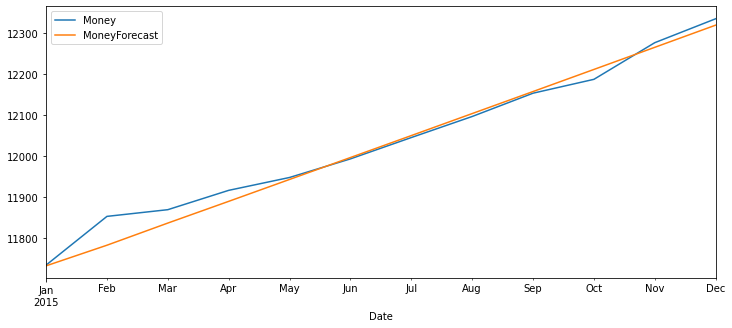

In [832]:
df["Money"][-obs:].plot(legend = True).autoscale(axis = 'x', tight = True)
final["MoneyForecast"].plot(legend = True);

In [834]:
rmse(df["Money"][-obs:],final["MoneyForecast"])

25.59139621047809

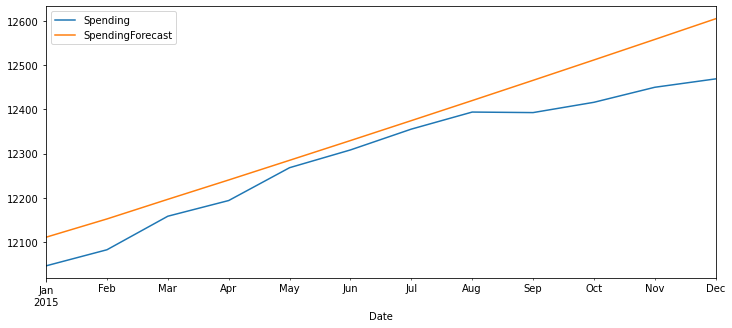

In [833]:
final["Spending"].plot(legend = True).autoscale(axis = 'x', tight = True)
final["SpendingForecast"].plot(legend = True);

In [835]:
rmse(df["Spending"][-obs:],final["SpendingForecast"])

70.23922396152142